(tess)=

# Fitting TESS data

In [82]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


In [83]:
def tic_id_from_simbad(other_id):
    #takes other_id (string) and queries Simbad to obtain the TIC ID
    
    from astroquery.simbad import Simbad
    ID_table = Simbad.query_objectids(other_id)
    if ID_table == None:
        return(None)
    
    ID_table['ID'] = ID_table['ID'].astype(str)
    

    ID_pandas = ID_table.to_pandas()
    tic_id = ID_pandas[ID_pandas['ID'].str.contains("TIC")]
    
    
    return tic_id['ID'].values[0]

In [84]:
def transit_info_from_exoplanet_archive(tic_id):
    #takes TIC ID and queries exoplanet archive to return t0, period, and duration
    
    import pyvo as vo
    from astropy import units as u


    service = vo.dal.TAPService("https://exoplanetarchive.ipac.caltech.edu/TAP")
    a = service.search("SELECT \
                       tic_id, pl_tranmid, pl_orbper, pl_trandur\
                       FROM pscomppars")
    exoplanets = a.to_table()
    exoplanets = exoplanets.to_pandas()

    column_dict = {
    'pl_tranmid':'t0 [BJD]',
    'pl_orbper':'period [days]',
    'pl_trandur':'duration [hours]',
    }
    exoplanets.rename(columns=column_dict, inplace=True)

    result = exoplanets[exoplanets['tic_id'] == tic_id]
    

    return result
    
    



In [85]:
def get_transit_info(planet_id):
    #takes a id, queries Simbad to get matching TIC ID
    #then queries exoplanet archive to extract t0, period, and duration
    #if no Simbad match found, then returns None and prints error message
    #if no exoplanet archive match found, then returns None and prints error message

    tic_id = tic_id_from_simbad(planet_id)
    if tic_id != None:
        transit_info = transit_info_from_exoplanet_archive(tic_id)
        if transit_info.empty:
            print("No TIC ID match found on exoplanet archive")
            return None
        
        else:
            return transit_info
            
    else:
        print("No TIC ID match found on Simbad")
        return None

In [86]:
def find_nearest(array, value):
    #returns the value in an array closest to another input value
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [142]:
def get_light_curve(planet_id, flux_type, TESS = False, Kepler = False):
    import numpy as np
    import lightkurve as lk
    from astropy.io import fits

    transit_info = get_transit_info(planet_id)
    if type(transit_info) == None:
        return None
    
    print(transit_info)
    
    tic_id = str(transit_info['tic_id'].values[0])
    periods = np.array(transit_info['period [days]'].values, dtype = float)
    t0s = np.array(transit_info['t0 [BJD]'].values, dtype = float)
    durations = np.array(transit_info['duration [hours]'].values, dtype = float)
    
    nplanets = len(periods)
    
    if TESS:
        #switch to TESS BJD
        t0s = t0s - 2457000
        
        #pull in TESS SPOC LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='TESS', author = 'SPOC'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    if Kepler:
        #switch to Kepler BJD
        t0s = t0s - 2454833
        
        #pull in Kepler LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='Kepler'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    

    lc = lc_files.stitch().remove_nans()
    
    xs = lc.time.value
    ys = lc.flux
    ys_err = lc.flux_err


    mask = np.zeros(np.shape(xs), dtype=bool)
    for ii in range(0, nplanets):
        masks = lc.create_transit_mask(period=periods[ii], duration=durations[ii]/24.*1.5, transit_time=t0s[ii])
        mask += masks
    

    lc_mask = lc[~mask]
    
    xs_mask = lc_mask.time.value
    ys_mask = lc_mask.flux
    ys_err_mask = lc_mask.flux_err

    min_time = xs.min()
    max_time = xs.max()

    
    t0s_all = []
    for ii in range(0, nplanets):
        t0 = t0s[0]
        period = periods[0]
        while t0 > min_time:
            t0 -= period

        
        while t0 < max_time:
            t0s_all.append(t0)
            t0 += period
    
    
    t0s_in_data = []
    for t0 in t0s_all:
        nearest_lc_time = find_nearest(xs, t0)
        if np.abs(t0 - nearest_lc_time) < 0.1: # 2.5 hours ~ 0.1 days
            t0s_in_data.append(t0)
            
            
    mu = np.mean(ys_mask)
    ys_mask = (ys_mask / mu - 1)
    ys = (ys / mu - 1)
            
    
    
    

    
    return \
        np.array(xs), np.array(ys), np.array(ys_err), \
        np.array(xs_mask), np.array(ys_mask), np.array(ys_err_mask), \
        np.array(t0s_in_data), periods, durations
    
    



In [143]:
time, lc, lc_err, time_mask, lc_mask, lc_err_mask, t0s, period, duration = get_light_curve('toi 1130', 'pdcsap_flux', TESS=True)

             tic_id      t0 [BJD]  period [days]  duration [hours]
351   TIC 254113311  2.458659e+06       4.066499              2.30
3206  TIC 254113311  2.458658e+06       8.350381              2.02


In [185]:
def get_light_curve_old(planet_id, planet_number, flux_type, TESS = False, Kepler = False):
    import numpy as np
    import lightkurve as lk
    from astropy.io import fits

    transit_info = get_transit_info(planet_id)
    if type(transit_info) == None:
        return None
    
    print(transit_info)
    
    tic_id = str(transit_info['tic_id'].values[planet_number])
    period = float(transit_info['period [days]'].values[planet_number])
    t0 = float(transit_info['t0 [BJD]'].values[planet_number])
    duration = float(transit_info['duration [hours]'].values[planet_number])   
    
    if TESS:
        #switch to TESS BJD
        t0 = t0 - 2457000
        
        #pull in TESS SPOC LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='TESS', author = 'SPOC'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    if Kepler:
        #switch to Kepler BJD
        t0 = t0 - 2454833
        
        #pull in Kepler LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='Kepler'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    

    lc = lc_files.stitch().remove_nans()
    
    xs = lc.time.value
    ys = lc.flux
    ys_err = lc.flux_err
    



    
        
    mask = lc.create_transit_mask(period=period, duration=duration/24.*1.5, transit_time=t0)
    

    lc_mask = lc[~mask]
    
    xs_mask = lc_mask.time.value
    ys_mask = lc_mask.flux
    ys_err_mask = lc_mask.flux_err

    min_time = xs.min()
    max_time = xs.max()

    while t0 > min_time:
        t0 -= period

    t0s = []
    while t0 < max_time:
        t0s.append(t0)
        t0 += period
    
    
    t0s_in_data = []
    for t0 in t0s:
        nearest_lc_time = find_nearest(xs, t0)
        if np.abs(t0 - nearest_lc_time) < 0.1: # 2.5 hours ~ 0.1 days
            t0s_in_data.append(t0)
            
            
    mu = np.mean(ys_mask)
    ys_mask = (ys_mask / mu - 1)
    ys = (ys / mu - 1)
            
    
    
    order = np.argsort(xs)
    xs = xs[order]
    ys = ys[order]
    ys_err = ys_err[order]
    
    
    
    order = np.argsort(xs_mask)
    xs_mask = xs_mask[order]
    ys_mask = ys_mask[order]
    ys_err_mask = ys_err_mask[order]

    
    return \
        np.array(xs), np.array(ys), np.array(ys_err), \
        np.array(xs_mask), np.array(ys_mask), np.array(ys_err_mask), \
        np.array(t0s_in_data), period, duration
    
    



In [194]:
def moving_median(time, flux, flux_err, time_window, sigma_window):
    '''
    input:
    time = array of time values
    flux = array of flux values
    flux_err = array of flux error values
    time_window = int, how many data points (in time space) around which to determine median on
    sigma_window = int, how many sigmas to clip
    
    
    returns:
    data:
        time_no_outliers = array of time values without outliers defined by moving median removed
        flux_no_outliers = array of flux values without outliers defined by moving median removed
        flux_no_outliers = array of flux error values without outliers defined by moving median removed
        time = array of all times to plot moving median
        moving_median = moving median value as array and length(flux) and length(time)
        time_outliers = array of time outliers defined by moving median removed
        flux_outliers = array of flux outliers defined by moving median removed
        flux_outliers = array of flux error outliers defined by moving median removed
        percent_outliers = percent of points that are outliers
    '''
    
    if len(time) != len(flux):
        print('error, mismatched time and flux data length')
    
    time_no_outliers = []
    flux_no_outliers = []
    flux_err_no_outliers = []
    
    moving_median = []
    
    time_outliers = []
    flux_outliers = []
    flux_err_outliers = []
    data = []
    for ii in range(0, len(time)):
        current_time = time[ii]
        current_flux = flux[ii]
        current_flux_err = flux_err[ii]
        
        indices = np.where(np.logical_and(time>=current_time-time_window, time<=current_time+time_window))[0]
        current_flux_median = np.median(flux[indices])
        moving_median.append(current_flux_median)
        


        if current_flux+sigma_window*current_flux_err >= current_flux_median and current_flux-sigma_window*current_flux_err <= current_flux_median:
            time_no_outliers.append(current_time)
            flux_no_outliers.append(current_flux)
            flux_err_no_outliers.append(current_flux_err)
            
        else:
            time_outliers.append(current_time)
            flux_outliers.append(current_flux)
            flux_err_outliers.append(current_flux_err)
            
    percent_outliers = np.round(100*(len(time_outliers) / (len(time_outliers)+len(time_no_outliers))),2)
    
    
    time_no_outliers = np.array(time_no_outliers)
    flux_no_outliers = np.array(flux_no_outliers)
    flux_err_no_outliers = np.array(flux_err_no_outliers)
        
    time_outliers = np.array(time_outliers)
    flux_outliers = np.array(flux_outliers)
    flux_err_outliers = np.array(flux_err_outliers)
    
    moving_median = np.array(moving_median)
    
    order = np.argsort(time_no_outliers)
    time_no_outliers = time_no_outliers[order]
    flux_no_outliers = flux_no_outliers[order]
    flux_err_no_outliers = flux_err_no_outliers[order]
    
    order = np.argsort(time)
    time = time[order]
    moving_median = moving_median[order]
    
    order = np.argsort(time_outliers)
    time_outliers = time_outliers[order]
    flux_outliers = flux_outliers[order]
    flux_err_outliers = flux_err_outliers[order]
    
    
    data = [time_no_outliers, flux_no_outliers, flux_err_no_outliers, time, moving_median, time_outliers, flux_outliers, flux_err_outliers, percent_outliers]

    return data

        

In [101]:
def plot_outliers(moving_median_data):
    '''
    input:
    data:
        time_no_outliers = array of time values without outliers defined by moving median removed
        flux_no_outliers = array of flux values without outliers defined by moving median removed
        flux_no_outliers = array of flux error values without outliers defined by moving median removed
        time_all = array of all times to plot moving median
        moving_median = moving median value as array and length(flux) and length(time)
        time_outliers = array of time outliers defined by moving median removed
        flux_outliers = array of flux outliers defined by moving median removed
        flux_outliers = array of flux error outliers defined by moving median removed
        percent_outliers = percent of points that are outliers
    '''
    
    [time_no_outliers, flux_no_outliers, flux_err_no_outliers, \
    time_all, moving_median, \
    time_outliers, flux_outliers, flux_err_outliers, 
    percent_outliers] = moving_median_data
    
    fig, ax = plt.subplots(1, 1, figsize = [18,6])
    ax.plot(time_no_outliers, flux_no_outliers, '.', color = '#381c5e', alpha = 0.5)
    ax.plot(time_outliers, flux_outliers, '.', color = '#ca3d7a', alpha = 0.5)
    ax.plot(time_all, moving_med, color = 'black', linestyle = 'dotted')
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    fig.show()
    
    return None

In [206]:
def plot_individual_lc(xs, ys, xs_mask, ys_mask, t0s_in_data, xlim):
    #xs = time
    #ys = flux
    #xs_mask = times not in transit
    #ys_mask = fluxed not in transit
    #t0s_in_data = midtransits in data
    #xlim = what fraction of the period to plot on either side of transit (ie. xlim=2 means 1/2 perio on either side)
    
    fig, ax = plt.subplots(nrows = len(t0s_in_data), figsize = [6,3*len(t0s_in_data)])
    if len(t0s_in_data) > 1:
        for ii in range(0, len(t0s_in_data)):
            t0 = t0s_in_data[ii]
            ax[ii].plot(xs, ys, '.', color = '#777acd', alpha = 0.5)
            ax[ii].plot(xs_mask, ys_mask, '.', color = '#381c5e', alpha = 0.5)
            [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
            ax[ii].set_xlabel("time [days]")
            ax[ii].set_ylabel("intensity")
            ax[ii].set_xlim(t0-(period/xlim), t0+(period/xlim))
        
    else:
        t0 = t0s_in_data[0]
        ax.plot(xs, ys, '.', color = '#777acd')
        ax.plot(xs_mask, ys_mask, '.', color = '#381c5e')
        [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
        ax.set_xlabel("time [days]")
        ax.set_ylabel("intensity")
        ax.set_xlim(t0-(period/xlim), t0+(period/xlim))
        
    fig.tight_layout()
    fig.show()
    
    return None

In [147]:
def plot_lc(xs, ys, xs_mask, ys_mask, t0s_in_data):
    #xs = time
    #ys = flux
    #xs_mask = times not in transit
    #ys_mask = fluxed not in transit
    #t0s_in_data = midtransits in data
    #xlim = what fraction of the period to plot on either side of transit (ie. xlim=2 means 1/2 perio on either side)
    
    fig, ax = plt.subplots(1, 1, figsize = [18,6])
    ax.plot(xs, ys, '.', color = '#777acd', alpha = 0.5)
    ax.plot(xs_mask, ys_mask, '.', color = '#381c5e', alpha = 0.5)
    [ax.axvline(_x, linewidth=1, color='k') for _x in t0s_in_data]
    ax.set_xlabel("time [days]")
    ax.set_ylabel("intensity")

        
    fig.tight_layout()
    fig.show()
    
    return None

In [199]:
#kepler 1513 = koi-3678
time, lc, lc_err, time_mask, lc_mask, lc_err_mask, t0s, period, duration = get_light_curve('kepler 1513', 'pdcsap_flux', Kepler=True)

            tic_id      t0 [BJD]  period [days]  duration [hours]
916  TIC 394177315  2.455111e+06     160.884651           10.7536


In [200]:
# 0.05 days ~ 1.2 hours
moving_median_data = moving_median(time_mask, lc_mask, lc_err_mask, 0.05, 4)

time_no_out = moving_median_data[0]
flux_no_out = moving_median_data[1]
flux_err_no_out = moving_median_data[2]

moving_med = moving_median_data[4]

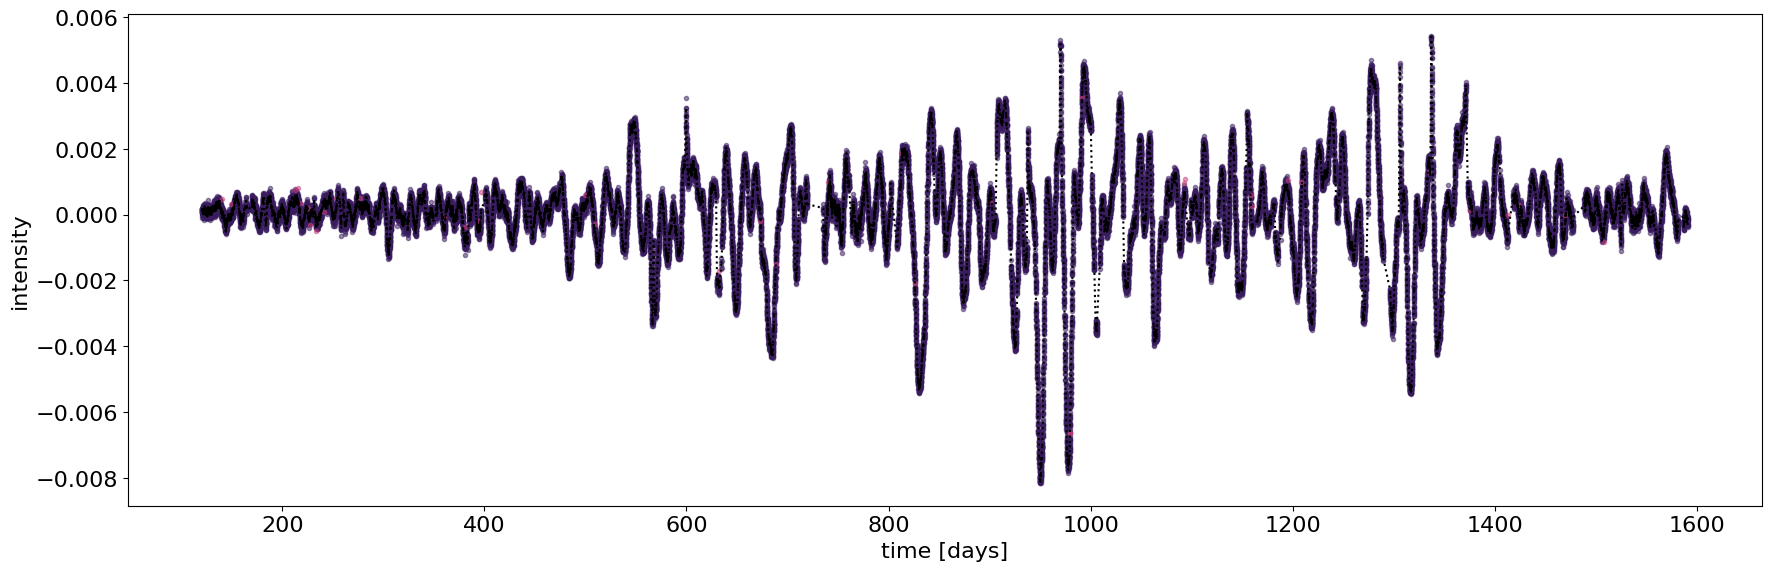

In [201]:
plot_outliers(moving_median_data)

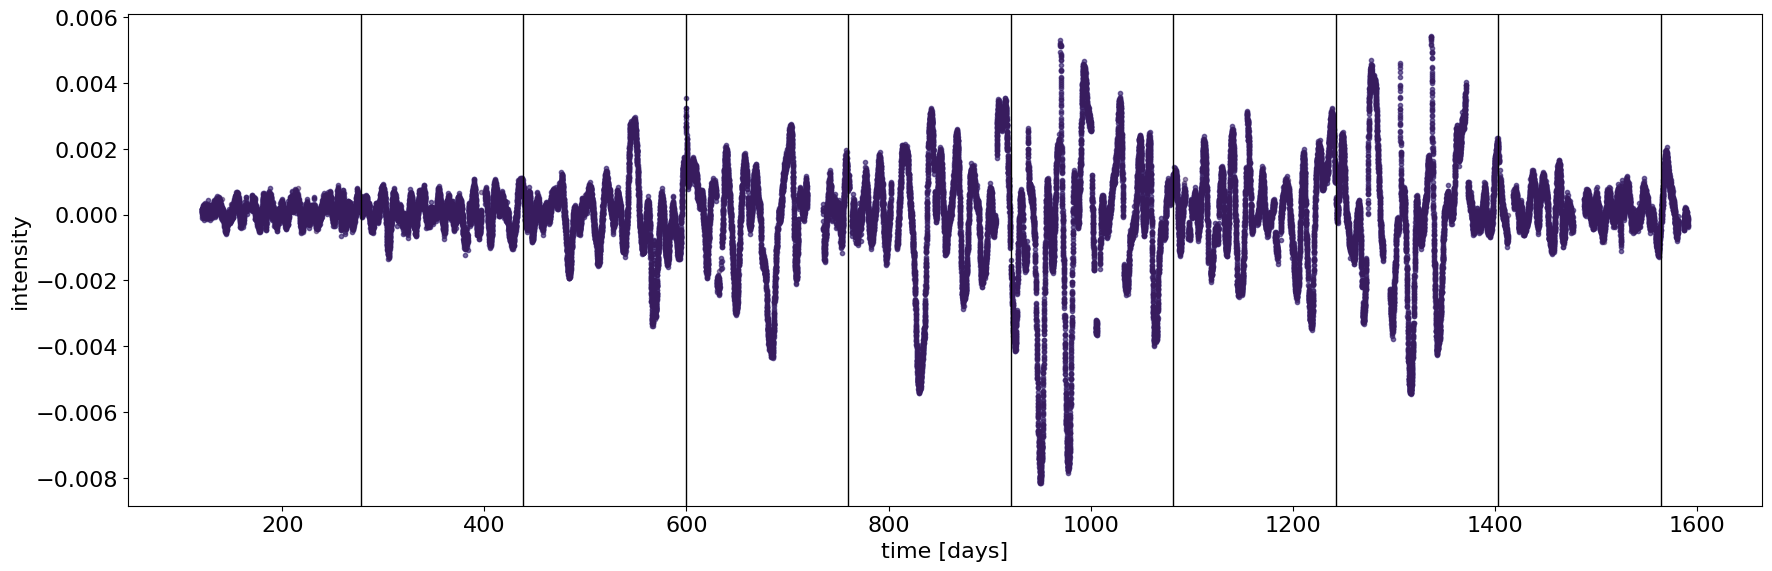

In [202]:
plot_lc(time_no_out, flux_no_out, time_mask, lc_mask, t0s)

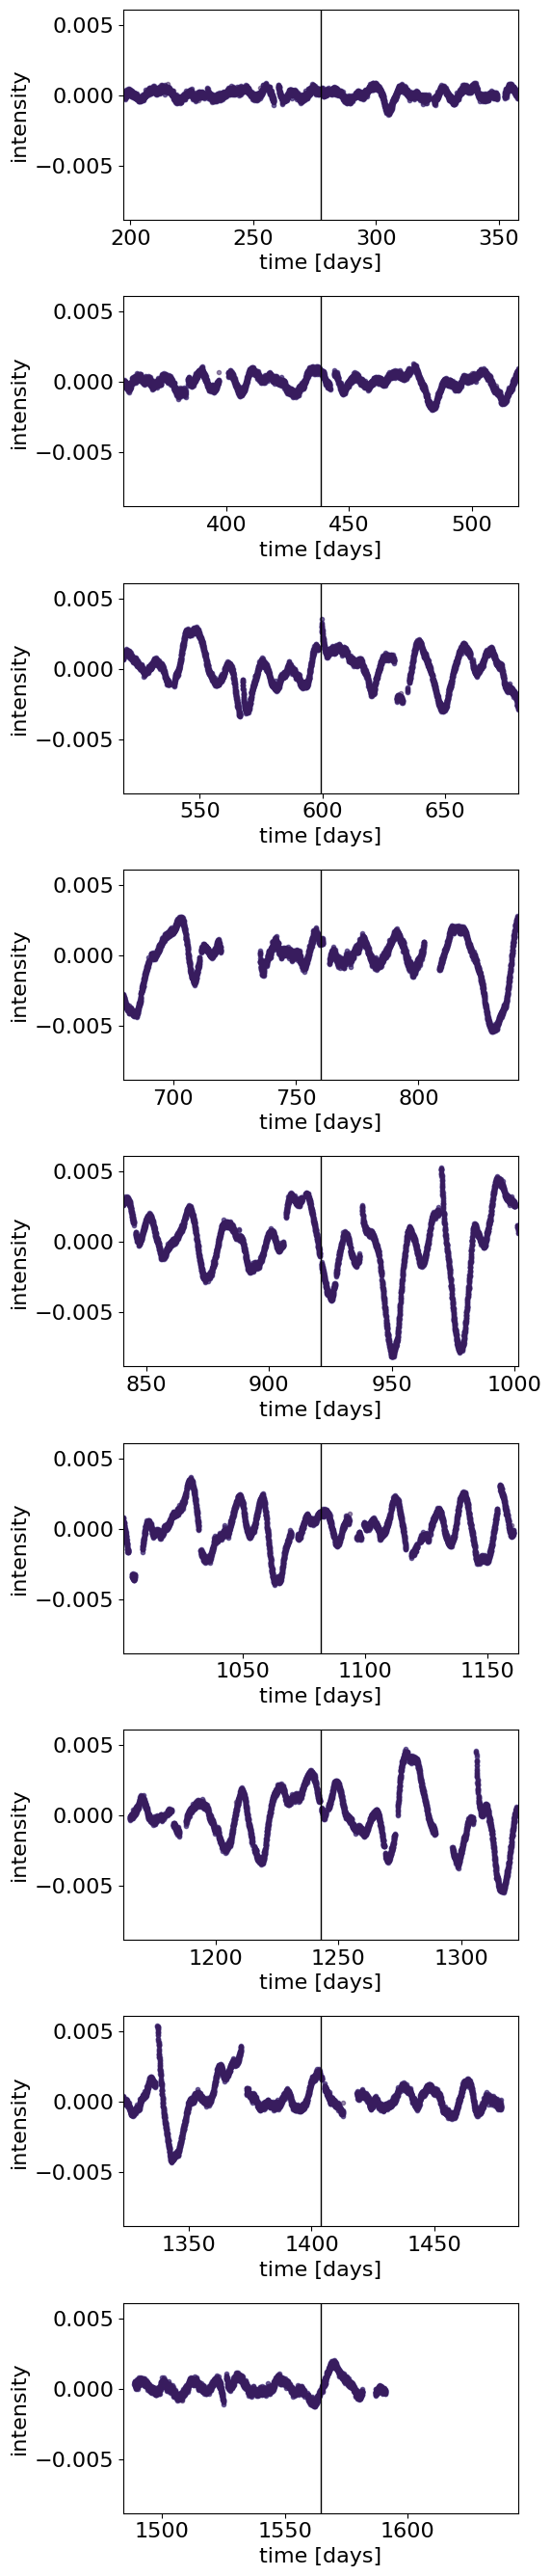

In [208]:
plot_individual_lc(time_no_out, flux_no_out, time_mask, lc_mask, t0s, 2)

In [ ]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(peak["period"]), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr ** 2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

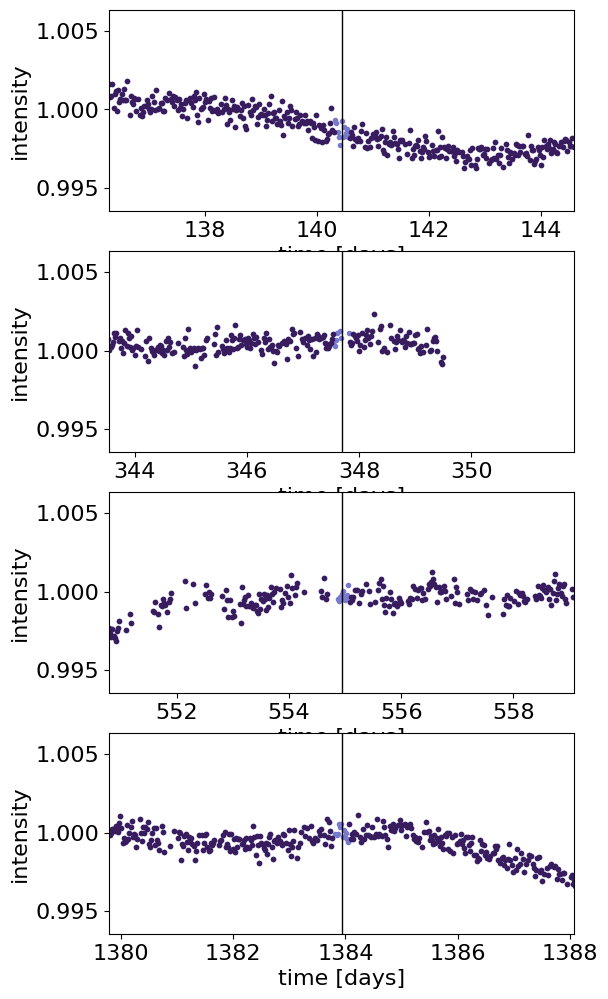

In [328]:
fig, ax = plt.subplots(nrows = len(t0s), figsize = [6,3*len(t0s)])
if len(t0s) > 1:
    for ii in range(0, len(t0s)):
        t0 = t0s[ii]
        ax[ii].plot(time, lc, '.', color = '#777acd')
        ax[ii].plot(time_mask, lc_mask, '.', color = '#381c5e')
        [ax[ii].axvline(_x, linewidth=1, color='k') for _x in t0s]
        ax[ii].set_xlabel("time [days]")
        ax[ii].set_ylabel("intensity")
        ax[ii].set_xlim(t0-(period/50.), t0+(period/50.))

In [ ]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    time_mask, lc_mask, max_peaks=1, min_period=0.1, max_period=2.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

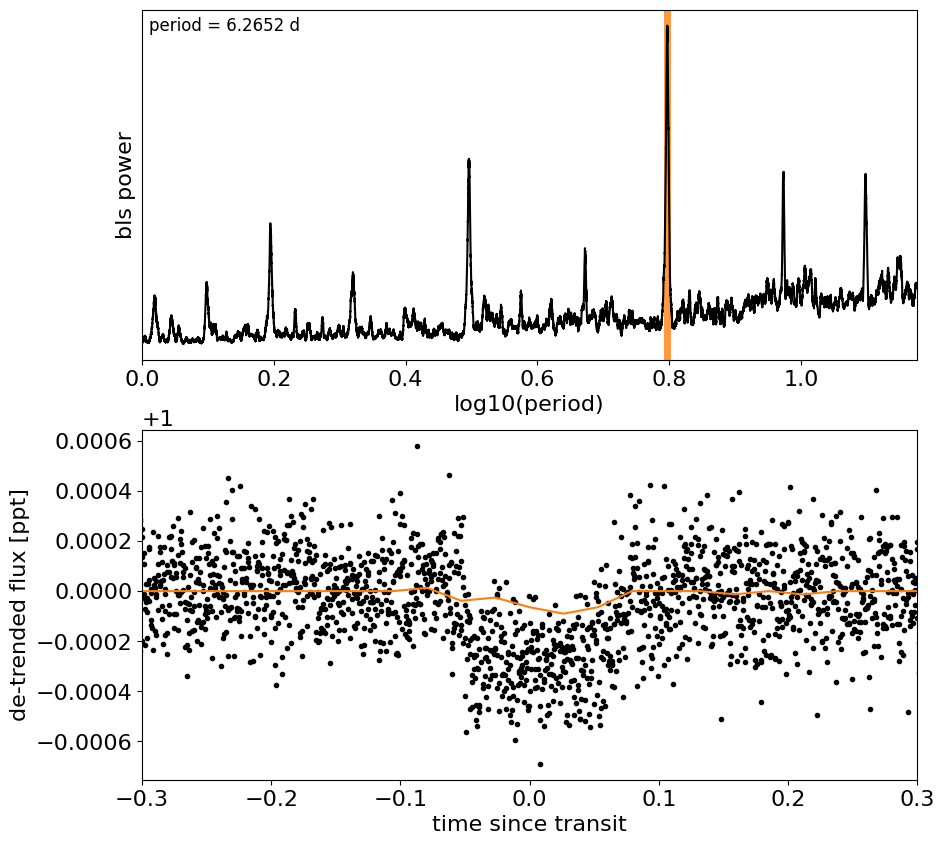

In [125]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], y[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in {ref}`joint`.

In [120]:
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from Huang et al (2018)
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star_huang[0], sd=M_star_huang[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star_huang[0], sd=R_star_huang[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        #         log_r_pl = pm.Normal(
        #             "log_r_pl",
        #             sd=1.0,
        #             mu=0.5 * np.log(1e-3 * np.array(bls_depth))
        #             + np.log(R_star_huang[0]),
        #         )
        #         r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        #         ror = pm.Deterministic("ror", r_pl / r_star)
        #         b = xo.distributions.ImpactParameter("b", ror=ror)

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
            * 1e3
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


model0, map_soln0, extras0 = build_model()

KeyboardInterrupt: 

Here's how we plot the initial light curve model:

In [ ]:
colors = ["#ff7e90", "#01993a", "#081f62", "#ffb951"]
def plot_light_curve(soln, extras, colors = colors, mask=None, figname=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(4, 1, figsize=(23, 18), sharex=True)
    
    
    index = 0
    ax = axes[index]
    ax.plot(x[mask], y[mask], "k", label="data", alpha=0.5)
    gp_mod = extras["gp_pred"] + soln["mean"]
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod+gp_mod, label="gp model + planet {0}".format(l), color=colors[index], lw=4)
    ax.legend(fontsize=18, loc=2)
    ax.set_ylabel("relative flux [ppt]")

    index = 1
    ax = axes[index]
    ax.plot(x[mask], y[mask], "k", label="data", alpha=0.5)
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color=colors[index], label="gp model", lw=4)
    ax.legend(fontsize=18, loc=2)
    ax.set_ylabel("relative flux [ppt]")

    index = 2
    ax = axes[index]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data", alpha=0.5)
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l), color=colors[index], lw=4)
    ax.legend(fontsize=18, loc=2)
    ax.set_ylabel("de-trended flux [ppb]")

    index = 3
    ax = axes[index]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k", alpha=0.5, label = 'O-C')
    ax.axhline(0, color=colors[index], lw=4)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    ax.legend(fontsize=18, loc=2)

    fig.tight_layout()
    if figname != None:
        fig.savefig(figname)
    return fig


_ = plot_light_curve(map_soln0, extras0, figname = './figures/lc.pdf')

As in {ref}`joint`, we can do some sigma clipping to remove significant outliers.

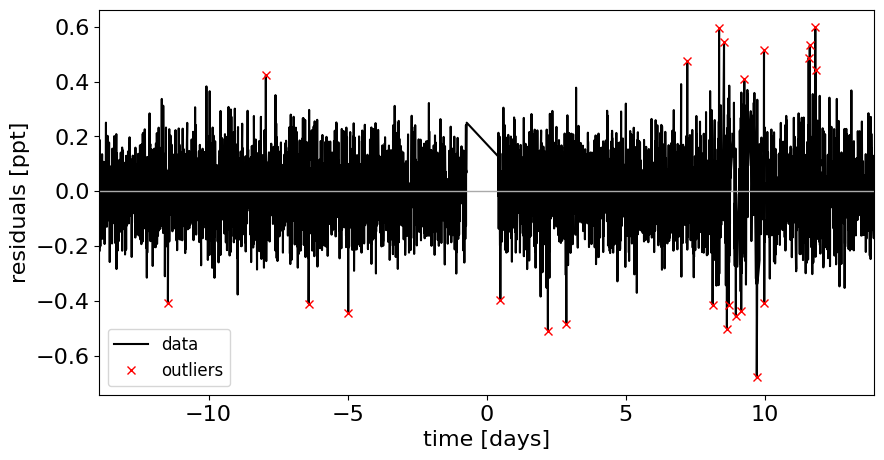

In [9]:
mod = (
    extras0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(extras0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

And then we re-build the model using the data without outliers.

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 3880.2624834369963 -> 3886.4398284722733
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: 3886.4398284722733 -> 3886.4414819635867
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 3886.4414819635867 -> 3886.441650511299
optimizing logp for variables: [t0, log_period]


message: Optimization terminated successfully.
logp: 3886.441650511299 -> 3886.4418199556812
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: 3886.4418199556812 -> 3886.441904693533
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: 3886.441904693533 -> 3886.441910230117
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 3886.441910230117 -> 3886.441920798151
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: 3886.441920798151 -> 3886.4419209230296
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 3886.4419209230296 -> 3886.4442107120994
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 3886.4442107120994 -> 3886.44422015159
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 3886.4442201515903 -> 3886.444243611819


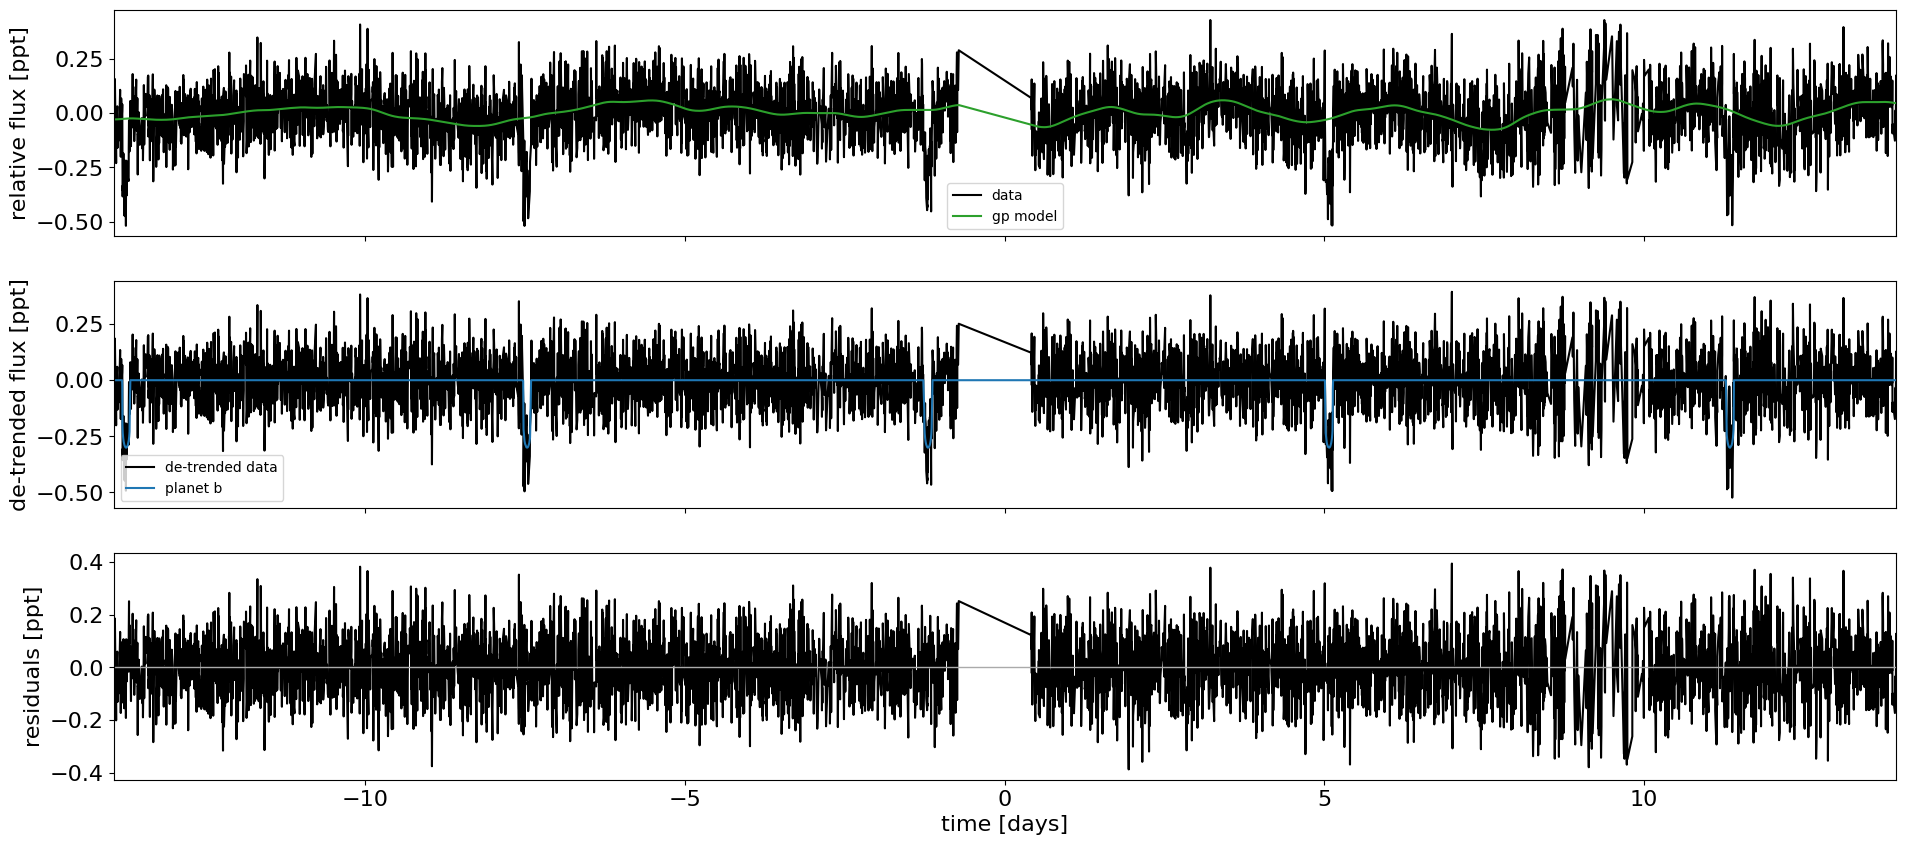

In [10]:
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

Now that we have the model, we can sample:

In [8]:
import platform

with model:
    trace = pm.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=1 if platform.system() == "Darwin" else 2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 678 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        "r_star",
        "m_star",
        "u_star",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.347,1.843,-2.829,3.110,0.071,0.050,725.0,687.0,1.01
ecc,0.222,0.146,0.000,0.487,0.006,0.005,712.0,470.0,1.00
r_pl,0.018,0.001,0.017,0.020,0.000,0.000,812.0,1355.0,1.00
b,0.479,0.222,0.032,0.806,0.015,0.011,189.0,123.0,1.01
t0,-13.735,0.002,-13.739,-13.730,0.000,0.000,1481.0,1362.0,1.00
period,6.269,0.001,6.267,6.270,0.000,0.000,1664.0,1653.0,1.00
r_star,1.100,0.023,1.058,1.146,0.001,0.000,1534.0,1405.0,1.00
m_star,1.093,0.038,1.020,1.160,0.001,0.001,1965.0,1335.0,1.00
u_star[0],0.305,0.231,0.001,0.712,0.005,0.004,1719.0,1338.0,1.00
u_star[1],0.223,0.314,-0.306,0.817,0.009,0.007,1295.0,1366.0,1.00


## Results

After sampling, we can make the usual plots.
First, let's look at the folded light curve plot:

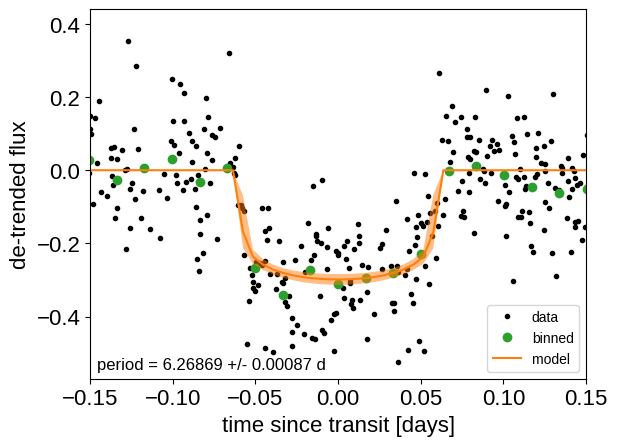

In [10]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = extras["gp_pred"] + map_soln["mean"]  # np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(
    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)

And a corner plot of some of the key parameters:

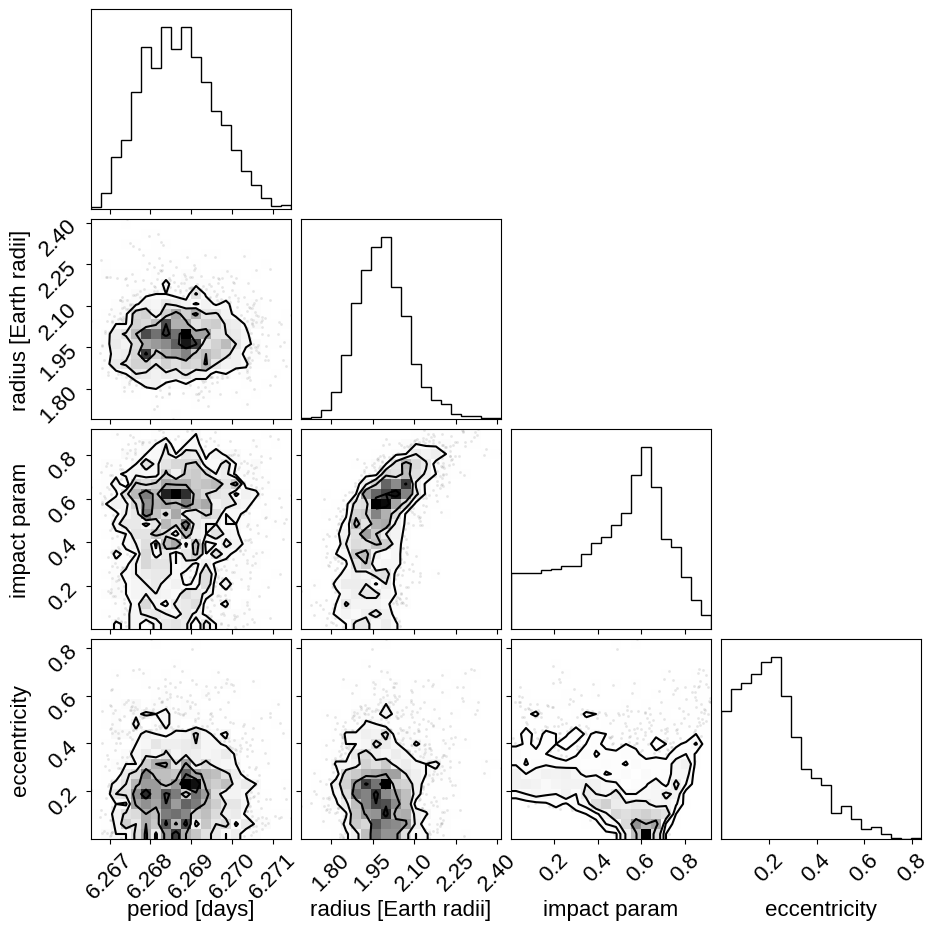

In [11]:
import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["period", "r_earth", "b", "ecc"],
    labels=[
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",
    ],
)

These all seem consistent with the previously published values.

## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{celerite2:foremanmackey17,
celerite2:foremanmackey18, exoplanet:agol20, exoplanet:arviz,
exoplanet:astropy13, exoplanet:astropy18, exoplanet:kipping13,
exoplanet:kipping13b, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [13]:
print(bib.split("\n\n")[0] + "\n\n...")


@article{exoplanet:joss,
       author = {{Foreman-Mackey}, Daniel and {Luger}, Rodrigo and {Agol}, Eric
                and {Barclay}, Thomas and {Bouma}, Luke G. and {Brandt},
                Timothy D. and {Czekala}, Ian and {David}, Trevor J. and
                {Dong}, Jiayin and {Gilbert}, Emily A. and {Gordon}, Tyler A.
                and {Hedges}, Christina and {Hey}, Daniel R. and {Morris},
                Brett M. and {Price-Whelan}, Adrian M. and {Savel}, Arjun B.},
        title = "{exoplanet: Gradient-based probabilistic inference for
                  exoplanet data \& other astronomical time series}",
      journal = {arXiv e-prints},
         year = 2021,
        month = may,
          eid = {arXiv:2105.01994},
        pages = {arXiv:2105.01994},
archivePrefix = {arXiv},
       eprint = {2105.01994},
 primaryClass = {astro-ph.IM},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2021arXiv210501994F},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System